In [13]:
# Import libraries
from dotenv import load_dotenv
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sqlalchemy import create_engine

In [14]:
# Load environment variables
load_dotenv()
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [15]:
# Connect to the Stack Overflow database
conn = psycopg2.connect(
    host=db_host,
    database=db_name,
    user=db_user,
    password=db_password
)

In [16]:
# With the env variables loaded we can insert them into the engine connection string.
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}")
connection = engine.connect()

In [17]:

# Define HEART metrics for Stack Overflow
heart_metrics = {
    'Happiness': 'Measure of user satisfaction and happiness with the Questions & Answers product.',
    'Engagement': 'Measure of user interaction and activity on the platform.',
    'Adoption': 'Measure of user acquisition and growth of Stack Overflow user base.',
    'Retention': 'Measure of user retention and continued usage of the platform over time.',
    'Task Success': 'Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.'
}

# Stack Overflow User Retention Analysis

This analysis will focus on the retention of Stack Overflow users and is based on the HEART metrics framework developed by Google. 


In [18]:
for metric, description in heart_metrics.items():
    print(f"{metric}: {description}")

Happiness: Measure of user satisfaction and happiness with the Questions & Answers product.
Engagement: Measure of user interaction and activity on the platform.
Adoption: Measure of user acquisition and growth of Stack Overflow user base.
Retention: Measure of user retention and continued usage of the platform over time.
Task Success: Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.


I will determine a users retention by comparing their creation_date with their last_access_date. I will then group the user into one of the below categories, based on the time delta between their creation and last access. In order to prevent a skew in the data caused by recently created accounts, I will only include accounts that are more than 1 year old in this analysis. I will also remove any accounts from the dataset with a time_delta value of 0. 

- Retained for less than 1 week
- Retained for between 1 week and 1 month
- Retained for between 1 and 3 months
- Retained for between 3 and 6 months
- Retained for between 6 months and 1 year
- Retained for 1 year or more

In [19]:
# Modify the SQL query to filter directly in the database
query = "SELECT creation_date, last_access_date " \
        "FROM users " \
        "WHERE creation_date <= CURRENT_DATE - interval '1 year' " \
        "AND last_access_date > creation_date"

# Fetch only the required data from the database
df = pd.read_sql(query, connection)

# Convert columns to datetime in pandas
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['last_access_date'] = pd.to_datetime(df['last_access_date'])

# Calculate time difference in pandas
df['time_delta'] = df['last_access_date'] - df['creation_date']

df


,creation_date,last_access_date,time_delta
0,2019-06-01 05:03:39.513,2021-07-13 21:07:53.230,773 days 16:04:13.717000
1,2019-06-01 05:03:43.730,2019-10-25 05:32:26.023,146 days 00:28:42.293000
2,2019-06-01 05:06:23.870,2021-06-08 07:45:46.490,738 days 02:39:22.620000
3,2019-06-01 05:06:37.193,2019-06-03 15:02:38.897,2 days 09:56:01.704000
4,2019-06-01 05:07:15.360,2020-02-20 19:14:58.857,264 days 14:07:43.497000
...,...,...,...
16148062,2019-06-01 04:57:28.913,2023-01-31 10:33:03.883,1340 days 05:35:34.970000
16148063,2019-03-08 16:12:04.950,2023-03-03 09:52:51.750,1455 days 17:40:46.800000
16148064,2019-06-01 04:58:23.460,2019-06-09 22:12:19.407,8 days 17:13:55.947000
16148065,2019-06-01 04:59:23.470,2019-10-03 09:52:45.143,124 days 04:53:21.673000


Now that we have extracted the necessary data from the database and calculated the time delta between creation a nd last activation we can group each entry into the appropriate category. This will enable use to plot each category.

In [41]:
# Calculate days, months, and years from time_delta
days = df['time_delta'].dt.days
months = df['time_delta'] // pd.Timedelta(days=30)
years = df['time_delta'] // pd.Timedelta(days=365)

# Initialize retention dictionary
retention = {
    "1 week": (days < 7).sum(),
    "1 month": ((days >= 7) & (months < 1)).sum(),
    "3 months": ((months >= 1) & (months < 3)).sum(),
    "6 months": ((months >= 3) & (months < 6)).sum(),
    "1 year": ((months >= 6) & (years < 1)).sum(),
    "2 years": ((years >= 1) & (years < 2)).sum(),
    "3 years": ((years >= 2) & (years < 3)).sum(),
    "4 years": ((years >= 3) & (years < 4)).sum(),
    "5 years": ((years >= 4) & (years < 5)).sum(),
    "6 years": ((years >= 5) & (years < 6)).sum(),
    "7 years": ((years >= 6) & (years < 7)).sum(),
    "8 years": ((years >= 7) & (years < 8)).sum(),
    "9 years": ((years >= 8) & (years < 9)).sum(),
    "10 years": ((years >= 9) & (years < 10)).sum(),
    "10+ years": (years >= 10).sum()
}
print("Here is the breakdown of user retention by timedelta:")
for key, value in retention.items():
    print(f"{key}: {value}")

Here is the breakdown of user retention by timedelta:
1 week: 2762481
1 month: 1655840
3 months: 2071923
6 months: 1670122
1 year: 1786157
2 years: 1761038
3 years: 1060770
4 years: 747349
5 years: 597758
6 years: 495869
7 years: 397745
8 years: 321450
9 years: 260622
10 years: 218317
10+ years: 340626


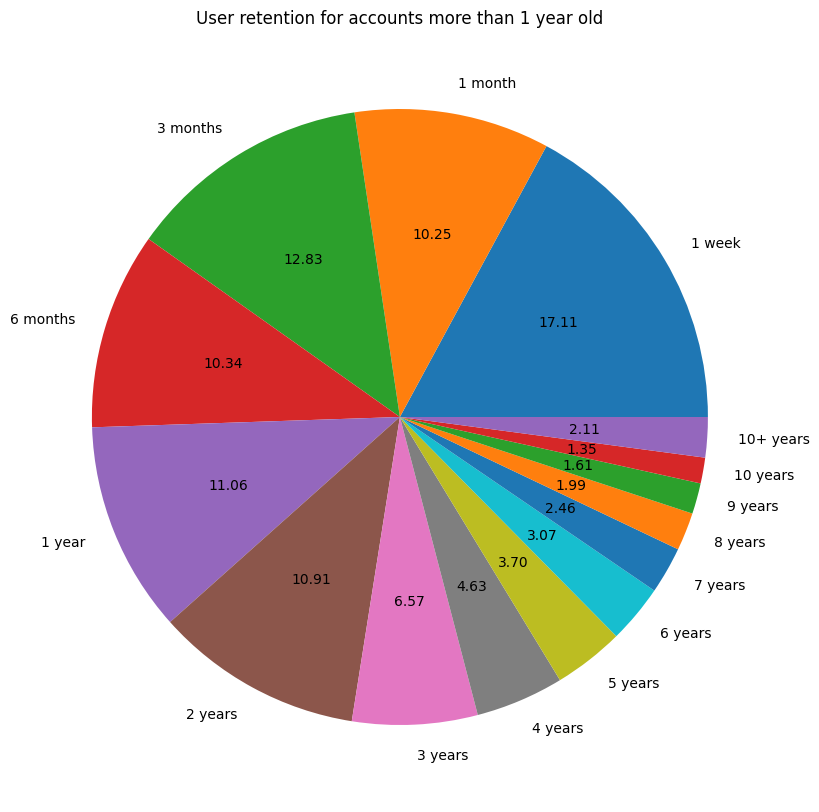

In [42]:
plt.figure(figsize=(10,10))
plt.pie(retention.values(), labels=retention.keys(), autopct='%.2f')
plt.title("User retention for accounts more than 1 year old")
plt.show()

From this chart we can see that the majority of user accounts are retained for less than 6 months with a total of 50.53% of user accounts in the database not being accessed more than 6 moths after being created. 

Whilst there is a steep drop off in the first six months, and a steady decline in retained accounts from year to year, the rate of loss does seem to decrease. I will plot this to see if a rate of decay can be calculated. In order to accurately represent any trend in the data I will plot the data by year, amalgamating the first 5 data points into year 1, and extend beyond 10 years to get a finer results for the longer retained accounts. 

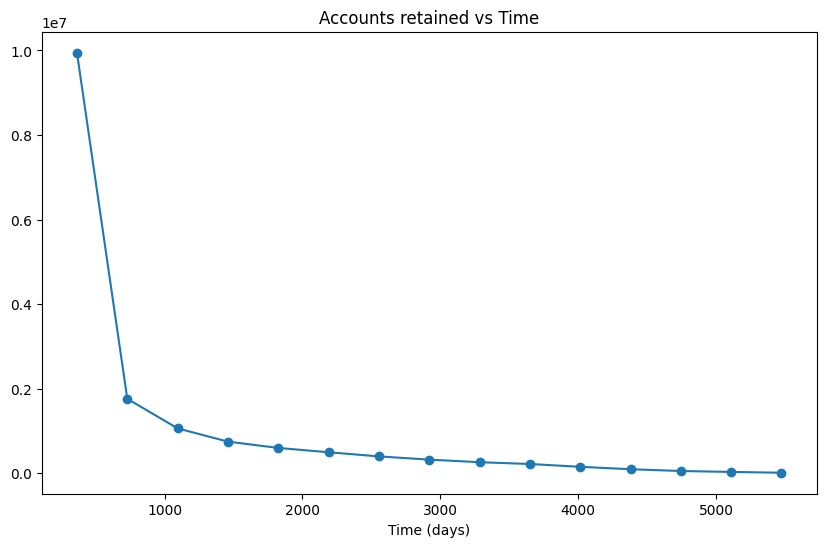

In [61]:
retention_yearly = {
    "1 year": (years < 1).sum(),
    "2 years": ((years >= 1) & (years < 2)).sum(),
    "3 years": ((years >= 2) & (years < 3)).sum(),
    "4 years": ((years >= 3) & (years < 4)).sum(),
    "5 years": ((years >= 4) & (years < 5)).sum(),
    "6 years": ((years >= 5) & (years < 6)).sum(),
    "7 years": ((years >= 6) & (years < 7)).sum(),
    "8 years": ((years >= 7) & (years < 8)).sum(),
    "9 years": ((years >= 8) & (years < 9)).sum(),
    "10 years": ((years >= 9) & (years < 10)).sum(),
    "11 years": ((years >= 10)  & (years < 11)).sum(),
    "12 years": ((years >= 11)  & (years < 12)).sum(),
    "13 years": ((years >= 12)  & (years < 13)).sum(),
    "14 years": ((years >= 13)  & (years < 14)).sum(),
    "15 years": ((years >= 14)  & (years < 15)).sum()
}

x = [i for i in range(365, 5840, 365)]
y = list(retention_yearly.values())

plt.figure(figsize=(10, 6))
plt.plot(x,y, marker='o')
plt.xlabel('Time (days)')
plt.title('Accounts retained vs Time')

plt.show()

This graph shows that the vast majority of accounts become inactive within the first year after being created. There is a significant drop in the number of accounts abandoned in their second year compared to their first. It also shows that the number of accounts being abandoned each year tends toward 0 over time. 

However, after that point the rate it which accounts are abandoned levels off significantly. There is a steady decline year on year which is to be expected, but for the most part we are able to come to the conclusion that if a user account is still active two years after creation then it is likely to continue to remain active in the following years. 